In [30]:
import numpy as np

import seaborn as sns
import pandas as pd
import os

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
from ecoli.processes.metabolism_redux import NetworkFlowModel, FlowResult, MetabolismRedux

FREE_RXNS = ["TRANS-RXN-145", "TRANS-RXN0-545", "TRANS-RXN0-474"]

sns.set(style='darkgrid', palette='viridis', context='talk')


# Import simulation output

Before running this, I ran a sim in ecoli/experiments/metabolism_redux_sim.py with -n 2 to generate a simulation output. This is necessary to replicate the simulation environment, where we e.g. have dynamic demand for amino acids and nucleotides, and varying cell volumes.

You don't have to do this for now. We'll use a single time step from the simulation output to test the network flow model on its own.

In [31]:
time = '50'
date = '2023-06-09'
experiment = 'fba-redux'
entry = f'{experiment}_{time}_{date}'
folder = f'out/fbagd/{entry}/'

In [32]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [33]:
# this is the model itself - we'll pull e.g. stoichiometry from here.
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

metabolism = agent['ecoli-metabolism-redux']
stoichiometry = metabolism.stoichiometry

# Check molecule exchanges from simulation - sanity check.

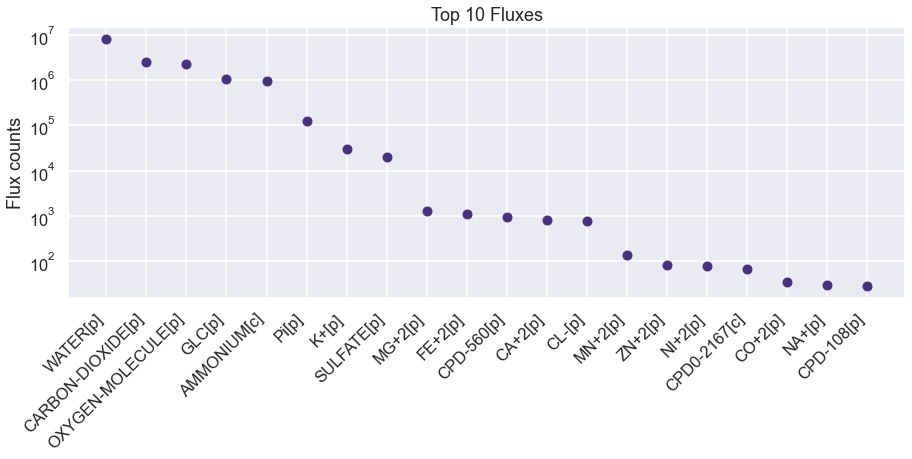

In [34]:
sim_exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"])
sim_exchanges = pd.DataFrame(sim_exchanges.loc[24, :].abs().sort_values(ascending=False))

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(sim_exchanges.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in sim_exchanges.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes')
plt.show()

# Check reaction fluxes from simulation - sanity check.

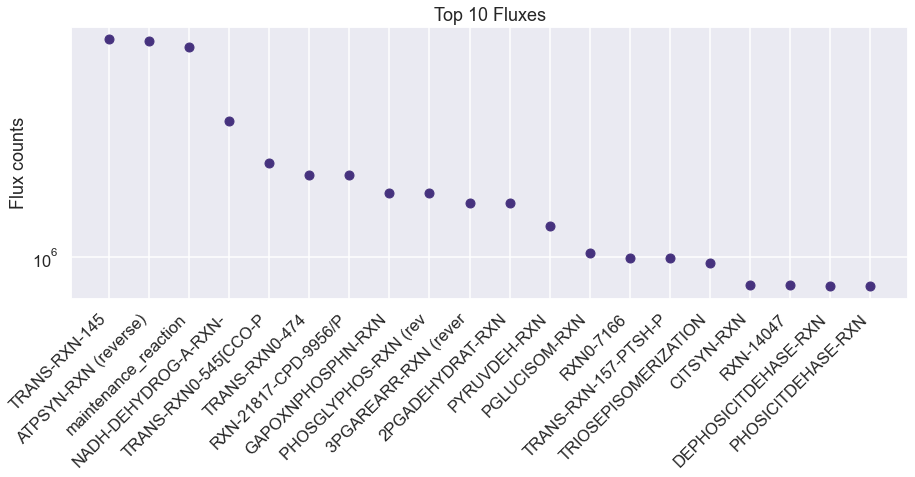

In [35]:
sim_fluxes = pd.DataFrame(fba["estimated_fluxes"], columns = metabolism.reaction_names)
sim_fluxes = pd.DataFrame(sim_fluxes.loc[24, :].abs().sort_values(ascending=False))


# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(sim_fluxes.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in sim_fluxes.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar


plt.ylabel('Flux counts')
# log scale
plt.yscale('log')
plt.title('Top 10 Fluxes')
plt.show()

In [36]:
sim_catalysts = pd.DataFrame(fba["reaction_catalyst_counts"], columns=metabolism.reaction_names)
sim_catalysts = pd.DataFrame(sim_catalysts.loc[4, :].abs().sort_values(ascending=False))
sim_catalysts

,4
RXN0-1741-MALTOSE//MALTOSE.17.,24833.0
RXN0-0-CPD0-1123//N-ACETYLNEURAMINATE.31.,24807.0
RXN-15315,24807.0
RXN0-0-CPD0-1122//CPD0-1122.21.,24807.0
RXN0-0-CPD0-1122//N-ACETYLNEURAMINATE.31.,24807.0
...,...
BETAGALACTOSID-RXN-Alpha-lactose/WATER//GALACTOSE/GLC.35.,0.0
BETAGALACTOSID-RXN-Alpha-lactose/WATER//GALACTOSE/Glucopyranose.45.,0.0
BETAGALACTOSID-RXN-CPD-15972/WATER//GALACTOSE/ALPHA-GLUCOSE.41.,0.0
BETAGALACTOSID-RXN-CPD-15972/WATER//GALACTOSE/GLC.31.,0.0


# Test changing nutrient composition

In [37]:
uptake = metabolism.allowed_exchange_uptake
uptake = set(uptake)

# addition = set(["CPD0-1074[c]"])
addition = set([
        # "FRU[p]",
        # "NITRATE[p]"
        # 'THIAMINE[p]',
        # 'HYDROGEN-MOLECULE[p]',
        # 'FUM[p]'
])
removals = set([
                  # "GLC[p]",
               #      # 'AMMONIUM[c]',
               #      # 'WATER[p]'
               #       # 'Pi[p]',
               #       # 'SULFATE[p]'
               # 'OXYGEN-MOLECULE[p]'
])


uptake = uptake | addition
uptake = uptake - removals
uptake

{'AMMONIUM[c]',
 'CA+2[p]',
 'CARBON-DIOXIDE[p]',
 'CL-[p]',
 'CO+2[p]',
 'FE+2[p]',
 'GLC[p]',
 'K+[p]',
 'L-SELENOCYSTEINE[c]',
 'MG+2[p]',
 'MN+2[p]',
 'NA+[p]',
 'NI+2[p]',
 'OXYGEN-MOLECULE[p]',
 'Pi[p]',
 'SULFATE[p]',
 'WATER[p]',
 'ZN+2[p]'}

# Use NetworkFlowModel class to run model

In [38]:
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).loc[24, :]
maintenance = pd.DataFrame(fba["maintenance_target"][1:], columns=['maintenance_reaction']).iat[24, 0]
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).loc[24, :]

In [39]:
model = NetworkFlowModel(
            stoich_arr=metabolism.stoichiometry,
            metabolites=metabolism.metabolite_names,
            reactions=metabolism.reaction_names,
            homeostatic_metabolites=list(dict(homeostatic).keys()),
            kinetic_reactions=list(dict(kinetic).keys()),
            free_reactions=FREE_RXNS)

In [40]:
model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=metabolism.allowed_exchange_uptake)

In [41]:
objective_weights = {'secretion': 0.01, 'efficiency': 0.0001, 'kinetics': 0.000001}
solution: FlowResult = model.solve(
            homeostatic_targets=np.array(list(dict(homeostatic).values())),
            maintenance_target=maintenance,
            kinetic_targets=np.array(list(dict(kinetic).values())),
            binary_kinetic_idx=[],
            objective_weights=objective_weights,
            upper_flux_bound=100000000)

In [42]:
pd.Series(solution.exchanges).abs().sort_values(ascending=False)

5182    8.249992e+06
639     2.490931e+06
4382    2.221422e+06
3617    1.074952e+06
446     9.069960e+05
            ...     
1775    0.000000e+00
1774    0.000000e+00
1773    0.000000e+00
1772    0.000000e+00
5313    0.000000e+00
Length: 5314, dtype: float64

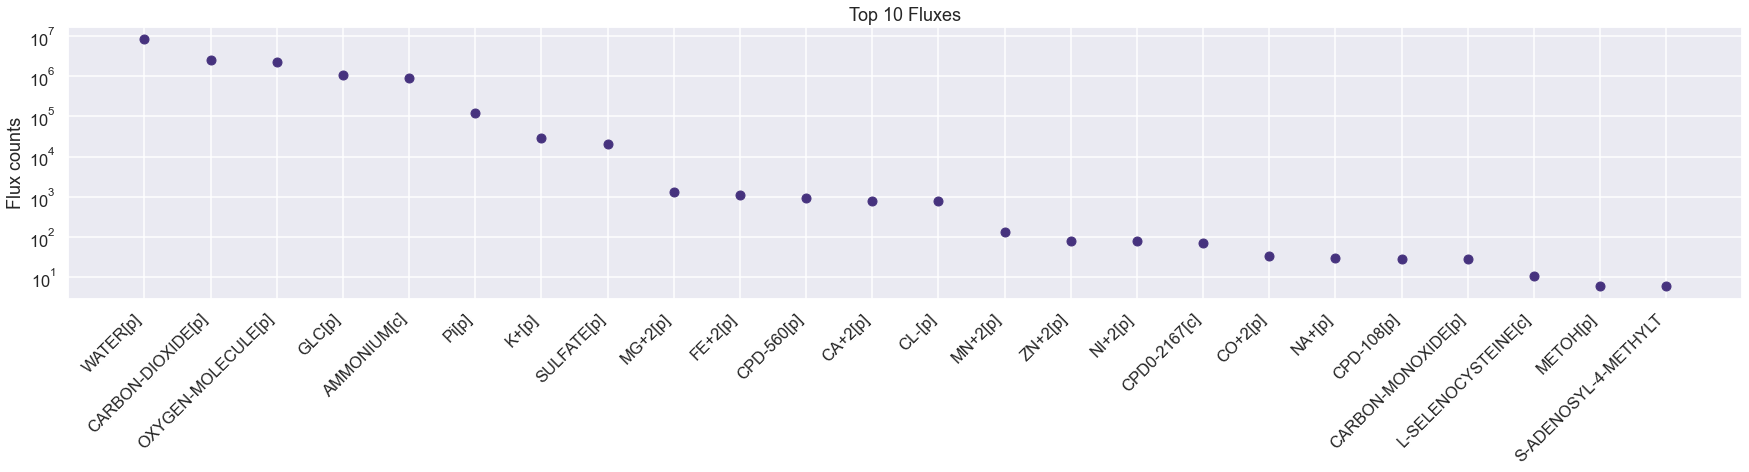

In [43]:
cur_exchanges = pd.Series(solution.exchanges, index=metabolism.metabolite_names).abs().sort_values(ascending=False)
nonzero = len(cur_exchanges[cur_exchanges > 0])

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(30, 5))
plt.plot(cur_exchanges.head(nonzero), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(nonzero)], [i[:20] for i in cur_exchanges.index[:nonzero]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes')
plt.show()

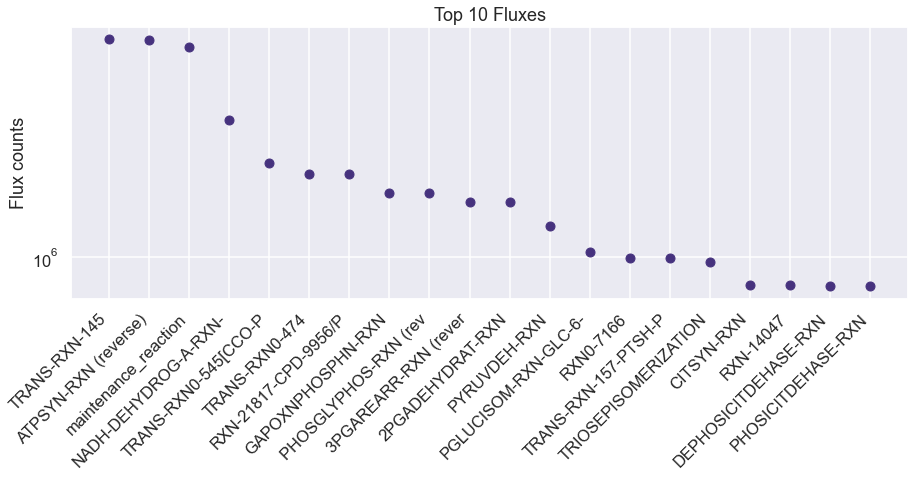

In [44]:
cur_fluxes = pd.Series(solution.velocities, index=metabolism.reaction_names).abs().sort_values(ascending=False)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(cur_fluxes.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in cur_fluxes.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes')
plt.show()

## Connect to EcoCyc to go from Genes -> Reactions

We use the EcoCyc API to automatically figure out what are made possible by the genes we are adding. While reactions are always possible, enzymes make them faster to the point that it is useful to the cell.

In [45]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})

<Response [200]>

In [21]:
condition_sets = {0: {"Environment": "Hydrogen + fumarate, -O2, -Glc",
                      "Genes": {"EG10468", "EG10469", "EG10470", "EG11799", "EG11800", "EG11801", "G7554"},
                      "Add": {"FUM[p]", 'HYDROGEN-MOLECULE[p]'},
                      "Remove": {"GLC[p]", "OXYGEN-MOLECULE[p]"},
                      },
                  
                  1: {"Environment": "Ribose C-source",
                      "Genes": {"EG10814", "EG10815", "EG10816", "EG10818"},
                      "Add": {"D-Ribopyranose[p]"},
                      "Remove": {"GLC[p]"},
                      },
                  
                  2: {"Environment": "Thiamine salvaging",
                      "Genes": {"EG11574", "G6566", "M007", "EG11573", "EG11572"},
                      "Add": {"THIAMINE[p]"},
                      "Remove": set(),
                      },
                  
                  3: {"Environment": "Nitrate as reduction target",
                      "Genes": {"EG10638", "EG10639", "EG10640", "EG10644", "EG10647", "EG10648"},
                      "Add": {"NITRATE[p]"},
                      "Remove": {"OXYGEN-MOLECULE[p]"},
                      },
                  
                  4: {"Environment": "3-Phenylpropionate as carbon and energy source",
                      "Genes": {"M010", "M011", "M012", "G6206"},
                      "Add": {"3-PHENYLPROPIONATE[p]"},
                      "Remove": {"GLC[p]"},
                      },

                  5: {"Environment": "Molybdenum cofactor synthesis",
                      "Genes": {"EG11595", "EG11666", "EG11597", "EG11598", "EG11829", "G7496", "EG10002", "EG10152",
                                "EG10153", "EG10154"},
                      "Add": {"CPD-3[p]"},
                      "Remove": set(),
                      "Demand": {"CPD-8123[c]"},
                      },

                  6: {"Environment": "pre-Quenosine synthesis",
                      "Genes": {"G6245", "G7431", "G7452"},
                      "Add": set(),
                      "Remove": set(),
                      "Demand": {"7-AMINOMETHYL-7-DEAZAGUANINE[c]"},
                      },


                  
                  # 5: {"Genes": set(["EG10286", "EG10287", "EG10288", "EG10289", 
                  #                   "EG10290", "EG10293", "EG10294", "EG10295", 
                  #                   "EG10296", "EG10298", "EG10302", "EG10303", 
                  #                   "EG10304", "EG10305", "EG10306", "G6414"]), 
                  #     "Add": set(),
                  #     "Remove": set(),
                  #     "Environment": "Proper metal (iron) uptake"}
                 }

condition_df = pd.DataFrame(condition_sets).T
condition_df["Reactions"] = [[np.nan]] * len(condition_df)
condition_df["Demand"] = condition_df["Demand"].fillna(False)
condition_df

,Environment,Genes,Add,Remove,Demand,Reactions
0,"Hydrogen + fumarate, -O2, -Glc","{G7554, EG11799, EG10469, EG11800, EG10470, EG...","{HYDROGEN-MOLECULE[p], FUM[p]}","{OXYGEN-MOLECULE[p], GLC[p]}",False,[nan]
1,Ribose C-source,"{EG10818, EG10814, EG10815, EG10816}",{D-Ribopyranose[p]},{GLC[p]},False,[nan]
2,Thiamine salvaging,"{G6566, M007, EG11572, EG11573, EG11574}",{THIAMINE[p]},{},False,[nan]
3,Nitrate as reduction target,"{EG10638, EG10648, EG10640, EG10647, EG10639, ...",{NITRATE[p]},{OXYGEN-MOLECULE[p]},False,[nan]
4,3-Phenylpropionate as carbon and energy source,"{M010, M011, M012, G6206}",{3-PHENYLPROPIONATE[p]},{GLC[p]},False,[nan]
5,Molybdenum cofactor synthesis,"{EG10152, G7496, EG11597, EG11829, EG10153, EG...",{CPD-3[p]},{},{CPD-8123[c]},[nan]
6,pre-Quenosine synthesis,"{G6245, G7452, G7431}",{},{},{7-AMINOMETHYL-7-DEAZAGUANINE[c]},[nan]


In [22]:
for i in range(len(condition_df.index)):
    
    genes = condition_df.loc[i, "Genes"]
    rxn_set = set()

    for gene in genes:
        function = "reactions-of-gene"
        name = gene
        req_str = f"https://websvc.biocyc.org/apixml?fn={function}&id=ECOLI:{name}&detail=none&fmt=json"

        r = s.get(req_str)
        o = xmltodict.parse(r.content)['ptools-xml']['Reaction']
        if type(o) is dict:
            o = [o]
        
        for rxn in o:
            if type(rxn) is not str: # no rxns
                rxn_set.add(rxn['@frameid'])
            else:
                print(gene, rxn)
            
    condition_df.at[i, "Reactions"] = rxn_set

In [23]:
condition_df

,Environment,Genes,Add,Remove,Demand,Reactions
0,"Hydrogen + fumarate, -O2, -Glc","{G7554, EG11799, EG10469, EG11800, EG10470, EG...","{HYDROGEN-MOLECULE[p], FUM[p]}","{OXYGEN-MOLECULE[p], GLC[p]}",False,"{RXN-16420, RXN0-5256, RXN0-7399}"
1,Ribose C-source,"{EG10818, EG10814, EG10815, EG10816}",{D-Ribopyranose[p]},{GLC[p]},False,"{RIBOKIN-RXN, ABC-28-RXN}"
2,Thiamine salvaging,"{G6566, M007, EG11572, EG11573, EG11574}",{THIAMINE[p]},{},False,"{RXN0-7298, ABC-32-RXN, THIKIN-RXN, THIAZOLSYN..."
3,Nitrate as reduction target,"{EG10638, EG10648, EG10640, EG10647, EG10639, ...",{NITRATE[p]},{OXYGEN-MOLECULE[p]},False,"{RXN0-7124, RXN-15119, RXN0-3501}"
4,3-Phenylpropionate as carbon and energy source,"{M010, M011, M012, G6206}",{3-PHENYLPROPIONATE[p]},{GLC[p]},False,"{1.13.11.16-RXN, RXN-10040, MHPHYDROXY-RXN, TR..."
5,Molybdenum cofactor synthesis,"{EG10152, G7496, EG11597, EG11829, EG10153, EG...",{CPD-3[p]},{},{CPD-8123[c]},"{RXN-21601, RXN-17809, RXN0-262, RXN-8342, RXN..."
6,pre-Quenosine synthesis,"{G6245, G7452, G7431}",{},{},{7-AMINOMETHYL-7-DEAZAGUANINE[c]},"{RXN0-4022, RXN0-5507, RXN-12093}"


## Quick and dirty loop (after init)

In [24]:
results_df = pd.DataFrame(columns=["Environment", "Reaction", "Flux"])

for i in range(len(condition_df)):
    condition_idx = i

    uptake = metabolism.allowed_exchange_uptake

    homeostatic = dict(pd.DataFrame(fba["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).loc[24, :])
    new_demand = condition_df.at[condition_idx, "Demand"]
    if new_demand:
        for met in new_demand:
            homeostatic[met] = 100

    uptake = set(uptake)

    addition = condition_df.at[condition_idx, "Add"]
    removals = condition_df.at[condition_idx, "Remove"]

    uptake = uptake | addition
    uptake = uptake - removals

    model = NetworkFlowModel(
            stoich_arr=metabolism.stoichiometry,
            metabolites=metabolism.metabolite_names,
            reactions=metabolism.reaction_names,
            homeostatic_metabolites=list(dict(homeostatic).keys()),
            kinetic_reactions=list(dict(kinetic).keys()),
            free_reactions=FREE_RXNS)

    model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=uptake)


    objective_weights = {'secretion': 0.01, 'efficiency': 0.0001, 'kinetics': 0.000001}
    solution: FlowResult = model.solve(
                homeostatic_targets=np.array(list(dict(homeostatic).values())),
                maintenance_target=maintenance,
                kinetic_targets=np.array(list(dict(kinetic).values())),
                binary_kinetic_idx=[],
                objective_weights=objective_weights,
                upper_flux_bound=100000000)

    # Check flux
    fluxes = pd.Series(solution.velocities, index=metabolism.reaction_names)
    # fluxes = pd.DataFrame({model.rxns[i]: [solution.velocities[model.rxns[i]]] for i in range(len(model.rxns))}).T
    fluxes.columns = ["Flux"]

    relevant_rxns = condition_df.at[condition_idx, "Reactions"]
    relevant_rxn_idx = []

    for rxn in relevant_rxns:
        relevant_rxn_idx.extend(list(np.where(fluxes.index.str.contains(rxn))[0] ))

    relevant_fluxes = fluxes.iloc[relevant_rxn_idx]
    
    relevant_nonzero_fluxes = relevant_fluxes[relevant_fluxes != 0]
    
    for j, k in enumerate(relevant_nonzero_fluxes.index):
        results_df = results_df.append(pd.DataFrame([[condition_df.at[condition_idx, "Environment"],
                          relevant_nonzero_fluxes.index[j],
                          relevant_nonzero_fluxes[k]]], columns=["Environment", "Reaction", "Flux"]))

    print(f"""finished {condition_df.at[condition_idx, "Environment"]}""")

finished Hydrogen + fumarate, -O2, -Glc
finished Ribose C-source
finished Thiamine salvaging
finished Nitrate as reduction target
finished 3-Phenylpropionate as carbon and energy source
finished Molybdenum cofactor synthesis
finished pre-Quenosine synthesis


In [25]:
results_df["Reaction"] = results_df['Reaction'].str.slice(0,20)
results_df["log(Flux)"] = np.log10(results_df["Flux"])
results_df

,Environment,Reaction,Flux,log(Flux)
0,"Hydrogen + fumarate, -O2, -Glc",RXN0-5256-CPD-9728/P,2.073151e+07,7.316631
0,Ribose C-source,RIBOKIN-RXN-CPD0-110,9.177517e+05,5.962725
0,Ribose C-source,RIBOKIN-RXN-CPD0-110,4.346074e+05,5.638097
0,Ribose C-source,ABC-28-RXN-ATP/D-Rib,1.352359e+06,6.131092
0,Thiamine salvaging,ABC-32-RXN,2.900000e+01,1.462398
0,Thiamine salvaging,THIKIN-RXN,2.900000e+01,1.462398
0,Nitrate as reduction target,RXN0-7124-NITRATE/CP,1.756030e+05,5.244532
0,Nitrate as reduction target,RXN0-3501-NITRATE/RE,1.300256e+06,6.114029
0,3-Phenylpropionate as carbon and energy source,1.13.11.16-RXN,7.993023e+05,5.902711
0,3-Phenylpropionate as carbon and energy source,MHPCHYDROL-RXN,7.993023e+05,5.902711


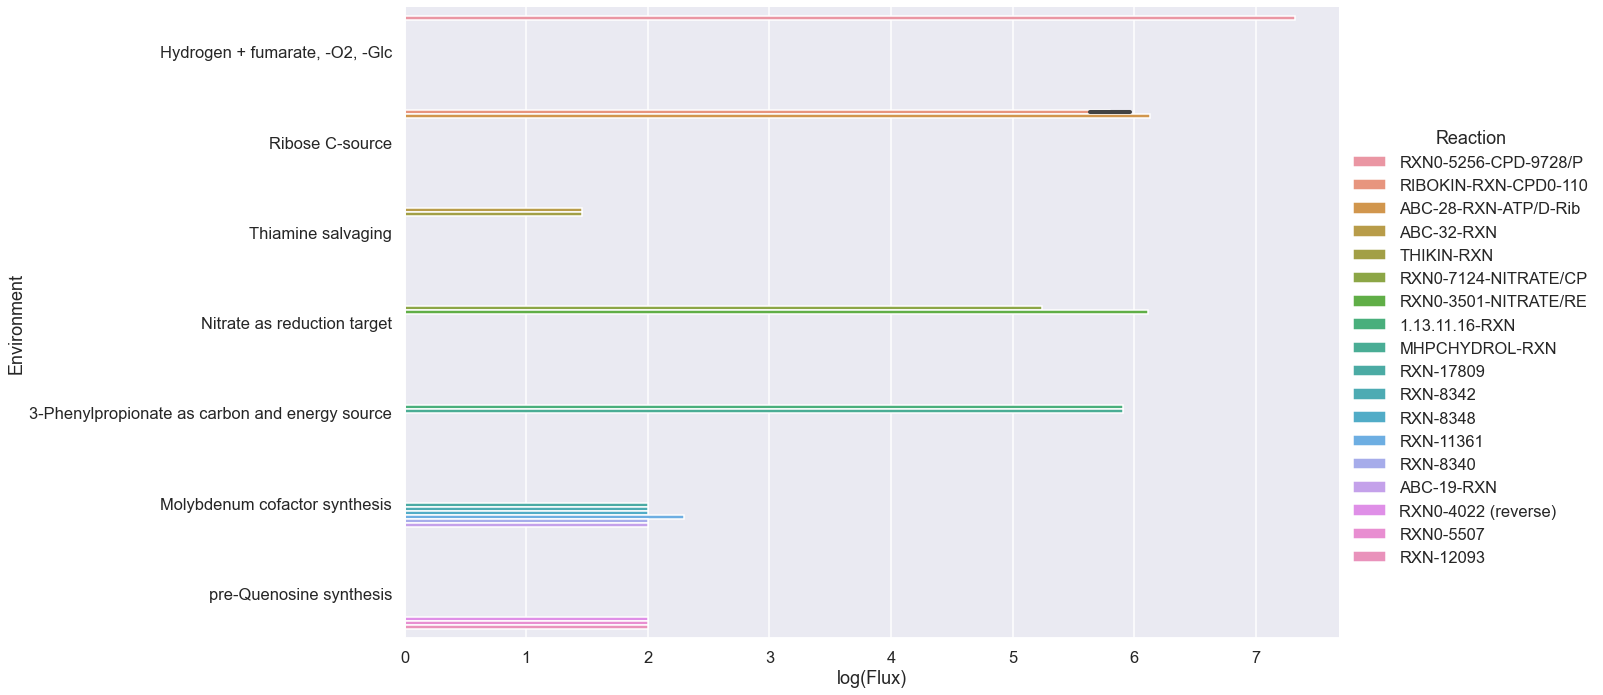

In [26]:
# for each environment, plot the fluxes of the reactions that are relevant to that environment
g = sns.catplot(y="Environment",hue="Reaction", x="log(Flux)", data=results_df, kind="bar", aspect=2, height=10, sharey=False)
g.savefig("notebooks/fbagd/figures/rxns_light_up.pdf")